In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model, tree, neighbors, ensemble, neural_network

df = pd.read_csv("..//static//csv//balanced_neo.csv")

## **1-я бизнес-цель (регрессия)**: 

Предсказание скорости космического объекта для принятия решения о том, насколько опасным он может быть и стоит ли вести за ним наблюдения

Целевой признак: скорость космического объекта relative_velocity

Вход: минимальный радиус est_diameter_min, максимальный радиус est_diameter_max, яркость объекта absolute_magnitude, расстояние от Земли miss_distance

Достижимый уровень качества: предсказания должны иметь погрешность в среднем не более 10000 км/с. Для проверки будет использоваться метрика MAE (средняя абсолютная ошибка)

In [4]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn import metrics
import sklearn.preprocessing as preproc
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from mlxtend.evaluate import bias_variance_decomp
from sklearn.neural_network import MLPRegressor

# Загрузка данных
df = pd.read_csv("..//static//csv//balanced_neo.csv")
data = df[['est_diameter_min', 'est_diameter_max', 'absolute_magnitude', 'miss_distance', 'relative_velocity']]

X = data.drop('relative_velocity', axis=1)
y = data['relative_velocity']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование числовых данных
#заполнение пустых значений медианой
num_imputer = SimpleImputer(strategy="median")

preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer)
    ]
)

#Категориальных данных нет, поэтому преобразовывать их не надо


# Общая предобработка (только числовые данные)
preprocessing = ColumnTransformer(
    [
        ("nums", preprocessing_num, X.columns)
    ]
)



## Линейная регрессия

In [ ]:
pipeline_lin_reg = Pipeline([
    ('preprocessing', preprocessing),
    ('model', LinearRegression())]
)

# Определение сетки гиперпараметров (возможных знач-ий гиперпараметров) для перебора
param_grid = {
    #как будут масштабироваться признаки
    'preprocessing': [StandardScaler(), preproc.MinMaxScaler(), preproc.MaxAbsScaler(), None]
}

# Создание объекта GridSearchCV для поиска лучших гиперпараметров по сетке с максимальным знач-ием 
# отрицательного корня из среднеквадратичной ошибки (отриц., чтобы искался не минимум, а максимум)
grid_search = GridSearchCV(pipeline_lin_reg, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

# Обучение модели с перебором гиперпараметров
grid_search.fit(X_train, y_train)

print("Лучшие гиперпараметры: ", grid_search.best_params_)

# Лучшая модель лин. регрессии
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print(f'Cредняя абсолютная ошибка (MAE) = {mean_absolute_error(y_test, y_pred)}')


# Оценка дисперсии и смещения
cv_results = grid_search.cv_results_
mean_test_score = cv_results['mean_test_score']
std_test_score = cv_results['std_test_score']

print(f"Смещение: {mean_test_score.mean()}")
print(f"Дисперсия: {std_test_score.mean()}")

from sklearn.metrics import r2_score

print(f'R^2 = {r2_score(y_test, y_pred)}')

Лучшие гиперпараметры:  {'preprocessing': MinMaxScaler()}
Cредняя абсолютная ошибка (MAE) = 19241.554618019443
Смещение: -24344.57878426918
Дисперсия: 219.3206565410472
R^2 = 0.18832948575910047


## Гребневая регрессия

In [ ]:
pipeline_ridge = Pipeline([
    ('preprocessing', preprocessing),
    ('model', Ridge())]
)

# Определение сетки гиперпараметров (возможных знач-ий гиперпараметров) для перебора
param_grid = {
    #как будут масштабироваться признаки
    'preprocessing': [StandardScaler(), preproc.MinMaxScaler(), preproc.MaxAbsScaler(), None],
    #сила регуляризации
    'model__alpha': [0, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0] 
}

# Создание объекта GridSearchCV для поиска лучших гиперпараметров по сетке с максимальным знач-ием 
# отрицательного корня из среднеквадратичной ошибки (отриц., чтобы искался не минимум, а максимум)
grid_search = GridSearchCV(pipeline_ridge, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=0)

# Обучение модели с перебором гиперпараметров
grid_search.fit(X_train, y_train)

print("Лучшие гиперпараметры: ", grid_search.best_params_)

# Лучшая модель регрессии
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print(f'Cредняя абсолютная ошибка (MAE) = {mean_absolute_error(y_test, y_pred)}')


cv_results = grid_search.cv_results_
mean_test_score = cv_results['mean_test_score']
std_test_score = cv_results['std_test_score']

print(f"Смещение: {mean_test_score.mean()}")
print(f"Дисперсия: {std_test_score.mean()}")

print(f'R^2 = {r2_score(y_test, y_pred)}')

Лучшие гиперпараметры:  {'model__alpha': 10.0, 'preprocessing': MinMaxScaler()}
Cредняя абсолютная ошибка (MAE) = 19239.098934204343
Смещение: -24500.751070720406
Дисперсия: 399.3445953588631
R^2 = 0.18843191913477164


Гребневая регрессия показала почти такие же результаты, что и линейная регрессия

## Метод градиентного бустинга (набор деревьев решений)

In [10]:
# Конвейер
pipeline_grad = Pipeline([
    ('preprocessing', preprocessing),
    ('model', GradientBoostingRegressor())
])

# Определение сетки гиперпараметров
param_grid = {
    'preprocessing': [StandardScaler(), preproc.MinMaxScaler(), preproc.MaxAbsScaler(), None],
    'model__n_estimators': [100, 200, 300],
    #Скорость обучения
    'model__learning_rate': [0.1, 0.2],
    #Максимальная глубина дерева
    'model__max_depth': [3, 5, 7]
}

# Создание объекта GridSearchCV
grid_search = GridSearchCV(pipeline_grad, param_grid, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1)

# Обучение модели с перебором гиперпараметров
grid_search.fit(X_train, y_train)

print("Лучшие гиперпараметры: ", grid_search.best_params_)

# Лучшая модель случайного леса
best_model = grid_search.best_estimator_


y_pred = best_model.predict(X_test)


print(f'Cредняя абсолютная ошибка (MAE) = {mean_absolute_error(y_test, y_pred)}')


# Получение предсказаний на кросс-валидации
y_cv_pred = cross_val_predict(best_model, X_train, y_train, cv=3)

cv_results = grid_search.cv_results_
mean_test_score = cv_results['mean_test_score']
std_test_score = cv_results['std_test_score']

print(f"Смещение: {mean_test_score.mean()}")
print(f"Дисперсия: {std_test_score.mean()}")

print(f'R^2 = {r2_score(y_test, y_pred)}')

Лучшие гиперпараметры:  {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100, 'preprocessing': None}
Cредняя абсолютная ошибка (MAE) = 18906.41250012098
Смещение: -24465.30968285963
Дисперсия: 186.25822491864383
R^2 = 0.21038509874388833


**Вывод**: 

Все 3 модели регрессии не показали необходимого уровня "погрешности". Также у всех моделей большое значение смещения, т.е. эти модели для задачи слишком простые. Необходимо использовать более сложные модели. Также возможно, что по доступным в датасете данным нельзя достичь необходимой погрешности.

Также низкое значение метрики R^2 у всех моделей показывает, что эти модели плохо объясняют вариацию целевой переменной.

Из всех моделей градиентный бустинг показал самую низкую "погрешность"

## **2-я бизнес-цель (классификация):** 

Определение опасности космиеского объекта для увеличения безопасности Земли

Целевой признак: опасность объекта hazardous

Вход: минимальный радиус est_diameter_min, максимальный радиус est_diameter_max, яркость объекта absolute_magnitude, скорость relative_velocity

Достижимый уровень качества: необходимо, чтобы точность предсказания модели составляла не менее 90%. Для проверки этого будет использована метрика Accuracy

In [6]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn import metrics
# Загрузка данных
df = pd.read_csv("..//static//csv//balanced_neo.csv")
data = df[['est_diameter_min', 'est_diameter_max', 'absolute_magnitude', 'relative_velocity', 'hazardous']]

X = data.drop('hazardous', axis=1)
y = data['hazardous']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование числовых данных
num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

# Общая предобработка (только числовые данные)
preprocessing = ColumnTransformer(
    [
        ("nums", preprocessing_num, X.columns),
    ]
)

## Логистическая регрессия

Лучшие гиперпараметры:  {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
ROC у логистической регрессии = 0.8670873798838691
Точность = 0.8591628959276018


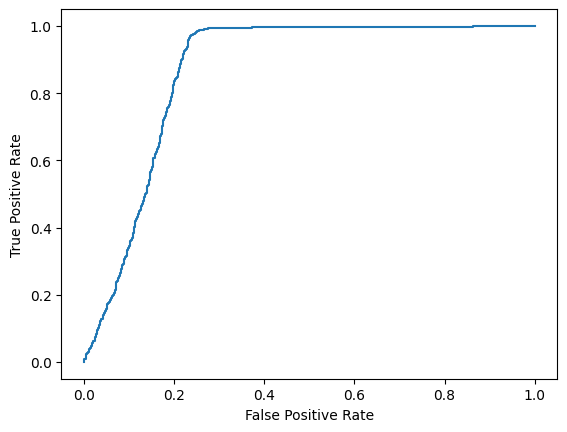

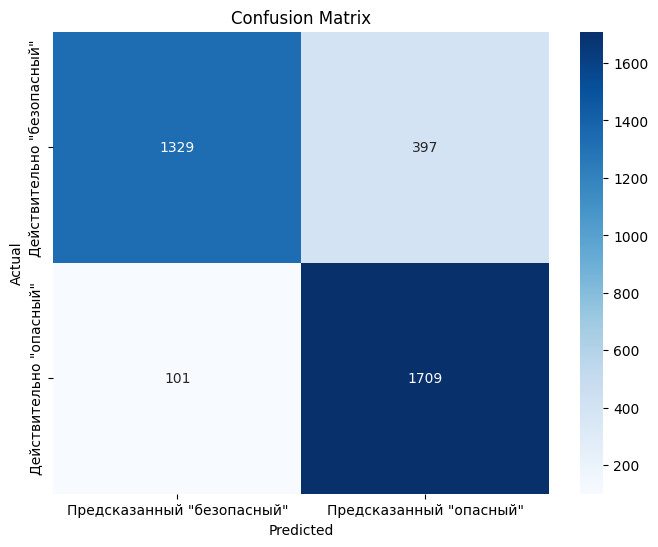

Смещение: 0.8529941124698746
Дисперсия: 0.0065558753718589465


In [7]:
# Конвейер для логистической регрессии
pipeline_logreg = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', LogisticRegression())
])

# Определение сетки гиперпараметров (возможных знач-ий гиперпараметров) для перебора
param_grid = {
    # Параметр регуляризации (сила регуляризации), чем меньше, тем сильнее регуляризация
    'classifier__C': [0.1, 0.5, 1],
    # Тип регуляризации (ф-ия штрафов)
    'classifier__penalty': ['l1', 'l2'],
    # Решатель (сам алгоритм?)
    'classifier__solver': ['liblinear', 'saga']
}

# Создание объекта GridSearchCV для поиска лучших гиперпараметров по сетке с максимальным знач-ием ROC-кривой
grid_search = GridSearchCV(pipeline_logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Обучение модели с перебором гиперпараметров
grid_search.fit(X_train, y_train)

print("Лучшие гиперпараметры: ", grid_search.best_params_)

# Лучшая модель логистической регрессии
best_model = grid_search.best_estimator_

# Использование и оценка лучшей логистической модели
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print(f'ROC у логистической регрессии = {roc_auc_score(y_test, y_pred_proba)}')

y_pred = best_model.predict(X_test)
print(f'Точность = {accuracy_score(y_test, y_pred)}')

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

# построение ROC кривой
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Построение матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Предсказанный "безопасный"', 'Предсказанный "опасный"'], 
            yticklabels=['Действительно "безопасный"', 'Действительно "опасный"'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Оценка дисперсии и смещения
cv_results = grid_search.cv_results_
mean_test_score = cv_results['mean_test_score']
std_test_score = cv_results['std_test_score']

print(f"Смещение: {mean_test_score.mean()}")
print(f"Дисперсия: {std_test_score.mean()}")

## Метод случаного леса (набор деревьев решений)

c:\AI labs\aimenv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Лучшие гиперпараметры:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 200}
ROC у метода случайного леса = 0.9009594886141752
Точность = 0.8721719457013575


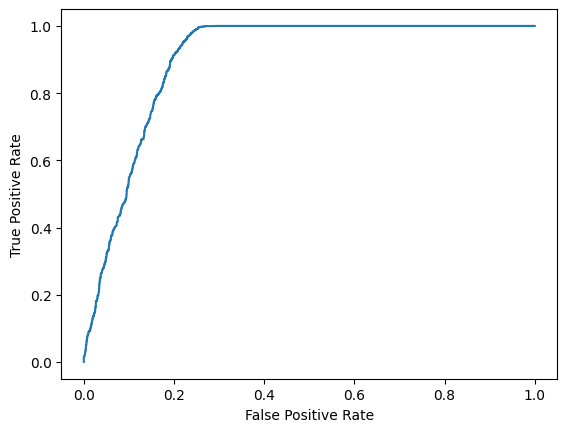

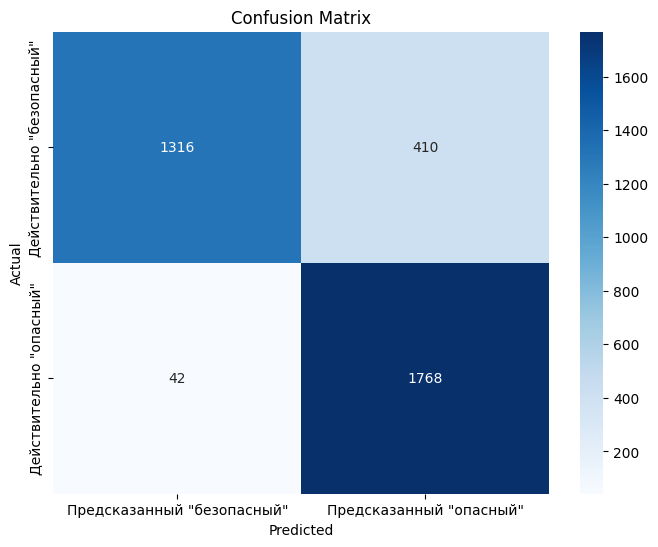

Смещение: 0.8684929985365014
Дисперсия: 0.003137100883428496


In [ ]:

# Конвейер для случайного леса
pipeline_ranfor = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', RandomForestClassifier())
])

# Определение сетки гиперпараметров
param_grid = {
    #Количество деревьев в лесу
    'classifier__n_estimators': [50, 100, 200],
    #Максимальная глубина дерева
    'classifier__max_depth': [10, 20, 30],
    #Минимальное количество образцов для листового узла
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Создание объекта GridSearchCV
grid_search = GridSearchCV(pipeline_ranfor, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Обучение модели с перебором гиперпараметров
grid_search.fit(X_train, y_train)

print("Лучшие гиперпараметры: ", grid_search.best_params_)

# Лучшая модель случайного леса
best_model = grid_search.best_estimator_

# Использование и оценка лучшей модели
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print(f'ROC у метода случайного леса = {roc_auc_score(y_test, y_pred_proba)}')

y_pred = best_model.predict(X_test)
print(f'Точность = {accuracy_score(y_test, y_pred)}')

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

# построение ROC кривой
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Построение матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Предсказанный "безопасный"', 'Предсказанный "опасный"'], 
            yticklabels=['Действительно "безопасный"', 'Действительно "опасный"'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Оценка дисперсии и смещения
cv_results = grid_search.cv_results_
mean_test_score = cv_results['mean_test_score']
std_test_score = cv_results['std_test_score']

print(f"Смещение: {mean_test_score.mean()}")
print(f"Дисперсия: {std_test_score.mean()}")


## Градиентный бустинг

Лучшие гиперпараметры:  {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 300, 'classifier__subsample': 0.5}
ROC у метода градиентного спуска = 0.9012421336337971
Точность = 0.872737556561086


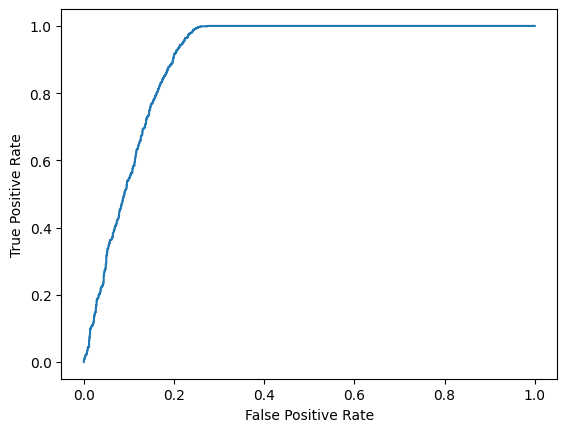

Матрица ошибок:
[[1326  400]
 [  50 1760]]


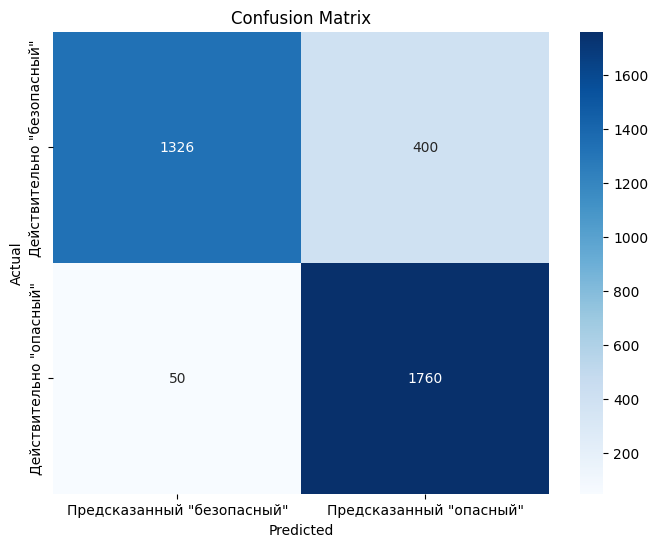

Смещение: 0.8811650848575816
Дисперсия: 0.008658656436943876


In [ ]:
# Конвейер
pipeline_grad = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', GradientBoostingClassifier())
])

# Определение сетки гиперпараметров
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    #Скорость обучения
    'classifier__learning_rate': [0.1, 0.2],
    #Максимальная глубина дерева
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.1, 0.5, 1.0],
}

# Создание объекта GridSearchCV
grid_search = GridSearchCV(pipeline_grad, param_grid, cv=2, scoring='roc_auc', n_jobs=-1)

# Обучение модели с перебором гиперпараметров
grid_search.fit(X_train, y_train)

print("Лучшие гиперпараметры: ", grid_search.best_params_)

# Лучшая модель
best_model = grid_search.best_estimator_

# Использование и оценка лучшей модели
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print(f'ROC у метода градиентного спуска = {roc_auc_score(y_test, y_pred_proba)}')

y_pred = best_model.predict(X_test)
print(f'Точность = {accuracy_score(y_test, y_pred)}')

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

# построение ROC кривой
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Построение матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Предсказанный "безопасный"', 'Предсказанный "опасный"'], 
            yticklabels=['Действительно "безопасный"', 'Действительно "опасный"'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Оценка дисперсии и смещения
cv_results = grid_search.cv_results_
mean_test_score = cv_results['mean_test_score']
std_test_score = cv_results['std_test_score']

print(f"Смещение: {mean_test_score.mean()}")
print(f"Дисперсия: {std_test_score.mean()}")

**Вывод**:

Все модели классификации показали хорошие результаты, но лучший показатель точности у случайного леса. При этом все рассмотренные модели немного не дотянули до показателя точности в 90%. Дополнительая настройка гиперпараметров могла бы приблизить значение оценки ещё ближе к 90%  